<i>Updated 19/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />

# AutoEncoder Analysis for MNIST dataset with Tensorflow 2 on Google Colab 
## MNIST データセットに対する AutoEncoder を Google Colab 上の Tensorflow 2を用いて解析する

In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# Check the execution environment on Google Colab
## Google Colab 上の実行環境を確認する

In [3]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 22 08:51:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab
## Google Colab から GoogleDrive をマウントする

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! ls /content/drive

MyDrive  Shareddrives


# Download the soure file from Google Drive or nw.tsuda.ac.jp

Basically, <code>gdown</code> from Google Drive. Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

## Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする

基本的に Google Drive から <code>gdown</code> してください。 Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [6]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True: # from Google Drive
    url_model = 'https://drive.google.com/uc?id=1ZDgWE7wmVwG_ZuQVUjuh_XHeIO-7Yn63'
    ! (cd {nw_path}; gdown {url_model})
else:    # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/AutoEncoder.py'
    ! wget -nd {url_model} -P {nw_path}     # download to './nw/AutoEncoder.py'

Downloading...
From: https://drive.google.com/uc?id=1ZDgWE7wmVwG_ZuQVUjuh_XHeIO-7Yn63
To: /content/nw/AutoEncoder.py
100% 13.9k/13.9k [00:00<00:00, 25.7MB/s]


In [7]:
! cat {nw_path}/AutoEncoder.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import datetime

class AutoEncoder():
    def __init__(self, 
                 input_dim,
                 encoder_conv_filters,
                 encoder_conv_kernel_size,
                 encoder_conv_strides,
                 decoder_conv_t_filters,
                 decoder_conv_t_kernel_size,
                 decoder_conv_t_strides,
                 z_dim,
                 use_batch_norm = False,
                 use_dropout = False,
                 epoch = 0
    ):
        self.name = 'autoencoder'
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_c

# Preparing the MNIST datasets
## MNIST データセットを用意する

In [8]:
import tensorflow as tf
import numpy as np

In [9]:
# MNIST datasets
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test_raw.shape)
print(y_test_raw.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [10]:
x_train = x_train_raw.reshape(x_train_raw.shape+(1,)).astype('float32') / 255.0
x_test = x_test_raw.reshape(x_test_raw.shape+(1,)).astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Load the Neural Network Model trained before.


Load the Neural Network Model trained in the AE_MNIST_Train.ipynb.
The definition of <code>AutoEncoder</code> class is downloaded from nw.tsuda.ac.jp.


## 学習済みのニューラルネットワーク・モデルをロードする

AE_MNIST_Train.ipynb で学習したニューラルネットワーク・モデルをロードする。
<code>AutoEncoder</code> クラスの定義は nw.tsuda.ac.jp からダウンロードした。

In [11]:
save_path1 = '/content/drive/MyDrive/ColabRun/AE01'
save_path2 = '/content/drive/MyDrive/ColabRun/AE02'
save_path3 = '/content/drive/MyDrive/ColabRun/AE03'

In [12]:
from nw.AutoEncoder import AutoEncoder
AE = AutoEncoder.load(save_path3)

In [13]:
print(AE.epoch)

200


In [14]:
# Load the AutoEncoder object of the specified epoch.
# 保存したAutoEncoderクラスのうち、指定したepochのオブジェクトをロードする。

AE_young = AutoEncoder.load(save_path3, 3)

print(AE_young.epoch)

3


# Display the distribution of points in the latent space.

Encode 10000 images of <code>x_test</code> to generated 2D coordinates and draw as points. The label of the image is expressed by the color of the dots.

## 潜在空間における点の分布を表示する

<code>x_test</code> の10000枚の画像をエンコードして2次元座標を生成し、点として描画する。各画像に描かれている数字は、点の色で表現する。

In [15]:
n_to_show = len(x_test)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test_raw[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

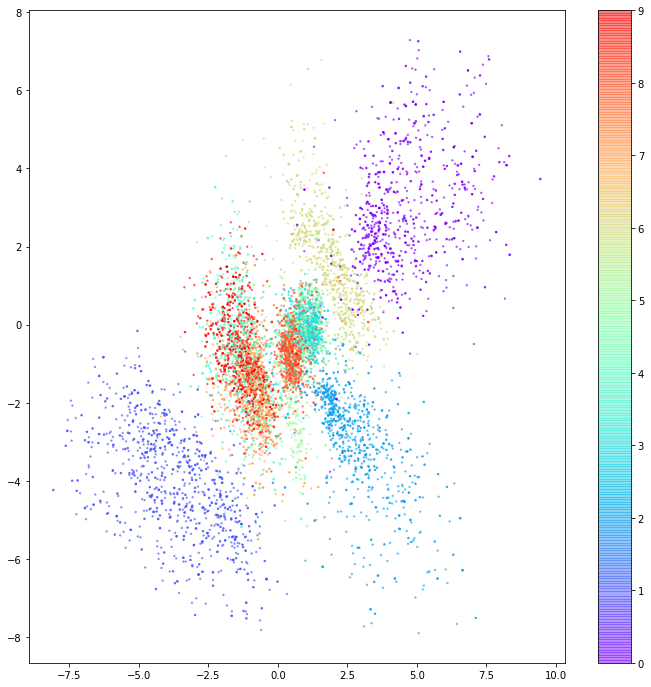

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

plt.colorbar(map)

plt.show()

In [17]:
# Display 30 images as points in the latent space.
# 30 枚の画像を潜在空間の点として表示する。
import numpy as np

table_row = 10 
table_line = 3

x = np.random.uniform(min_x, max_x, size=table_line * table_row)
y = np.random.uniform(min_y, max_y, size=table_line * table_row)
z_grid = np.array(list(zip(x,y)))    # (x, y) : 2D coordinates
reconst = AE.decoder.predict(z_grid)

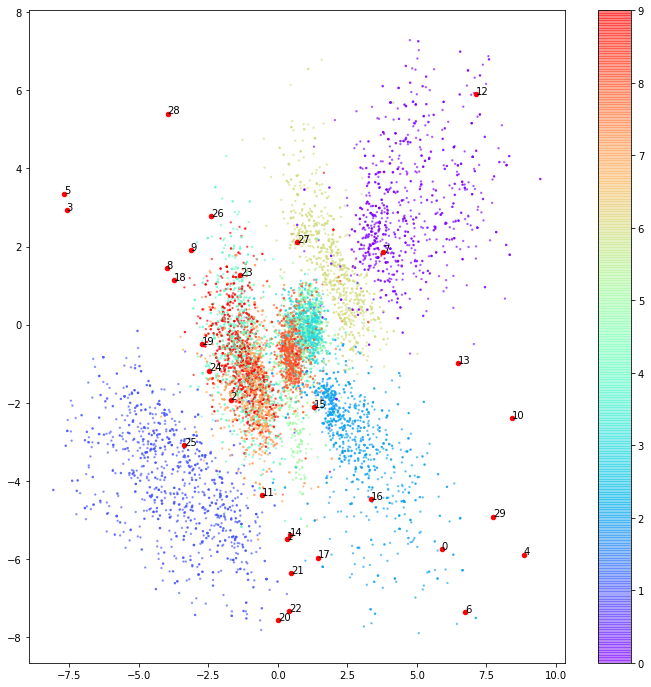

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

ax.scatter(z_grid[:,0], z_grid[:,1], c='red', alpha=1, s=20)

for i in range(len(z_grid)):
    ax.text(z_grid[i][0], z_grid[i][1], str(i))

plt.colorbar(map)

plt.show()

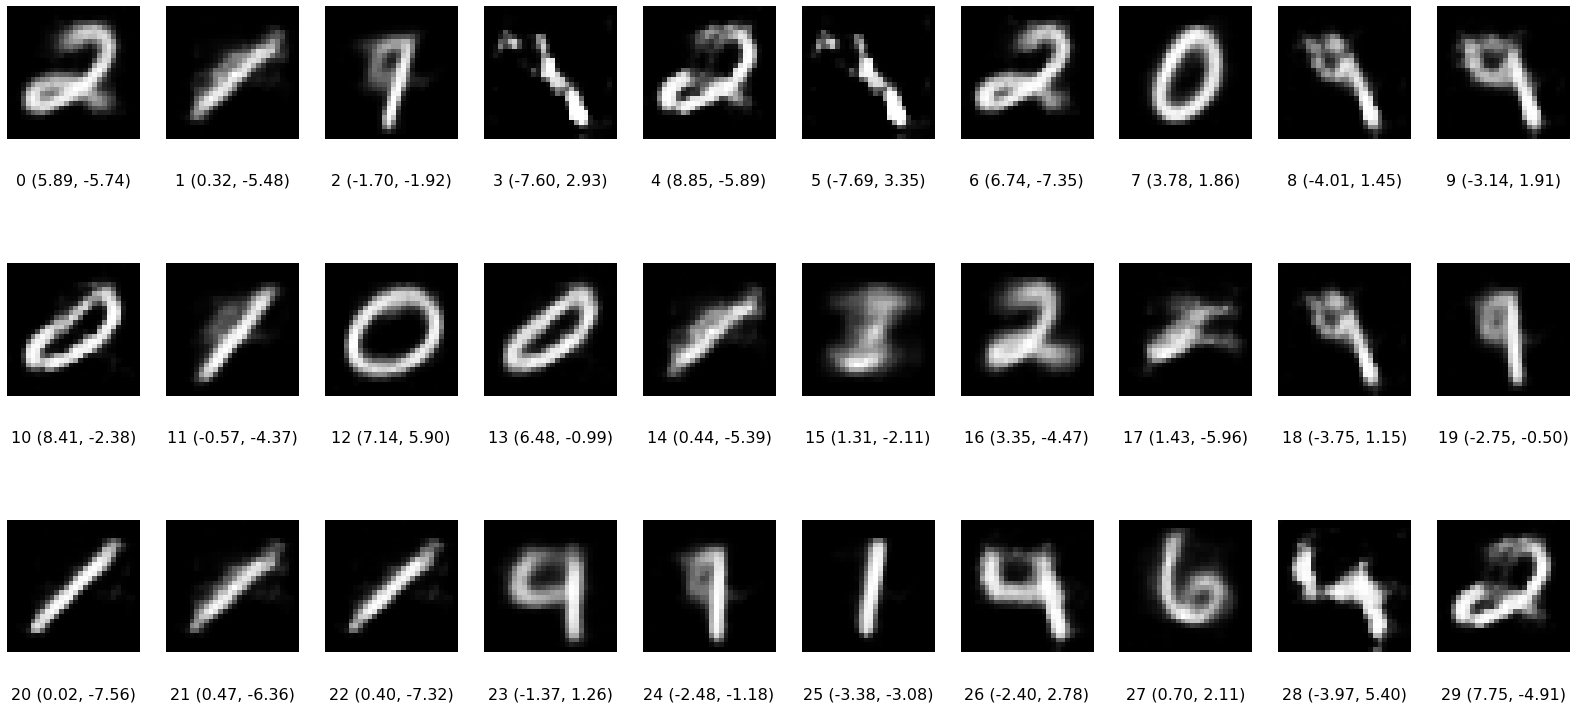

In [19]:
# Display the 30 original images selected as samples.
# サンプルとして選んだ30枚の元画像を表示する
%matplotlib inline
import matplotlib.pyplot as plt

VSKIP=0.5   # vertical space between subplots

fig, ax = plt.subplots(table_line, table_row, figsize=(2.8 * table_row, 2.8 * table_line * (1+VSKIP)))
plt.subplots_adjust(hspace = VSKIP)
                       
for y in range(table_line):
    for x in range(table_row):
        idx = table_row * y + x
        img = reconst[idx].squeeze()
        ax[y][x].imshow(img, cmap='gray')
        ax[y][x].text(0.5, -0.35, f'{idx} ({z_grid[idx][0]:.2f}, {z_grid[idx][1]:.2f})', fontsize=16, ha='center', transform=ax[y][x].transAxes)
        ax[y][x].axis('off')
        
plt.show()

# Divide the latent space into grids and find out what kind of image is generated (decoded) from each coordinates.

Generate images from points on 20x20 grid.
The generated images are displayed as a table with 20 rows and 20 columns.


## 潜在空間をグリッドに区切って、各座標からどのような画像が生成(デコード)されるか調べる

20×20  のグリッドから、画像を生成する。 生成した画像は 20 行 20列の表として表示する。

In [20]:
import numpy as np

n_grid = 20

x = np.linspace(min_x, max_x, n_grid)
y = np.linspace(min_y, max_y, n_grid)

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid2 = np.array(list(zip(xv, yv)))

reconst2 = AE.decoder.predict(z_grid2)

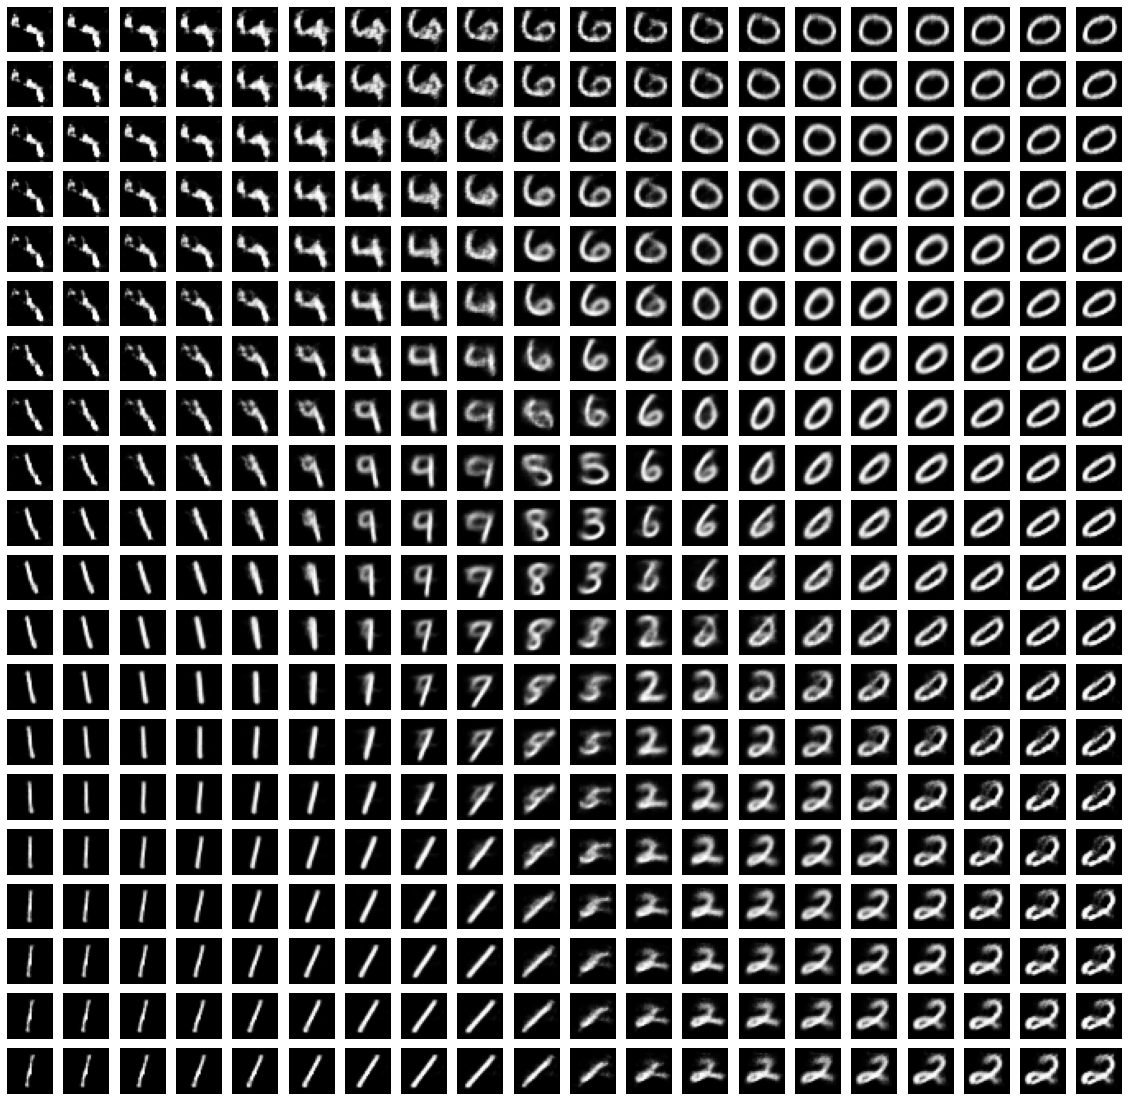

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(n_grid, n_grid, figsize=(n_grid, n_grid))
for i in range(len(reconst2)):
    img = reconst2[i].squeeze()
    line = n_grid - 1 - i // n_grid
    row = i % n_grid
    ax[line][row].imshow(img, cmap='gray')
    ax[line][row].axis('off')
    
plt.show()

# Draw a grid in the latent space.
## グリッドを潜在空間に描画する。

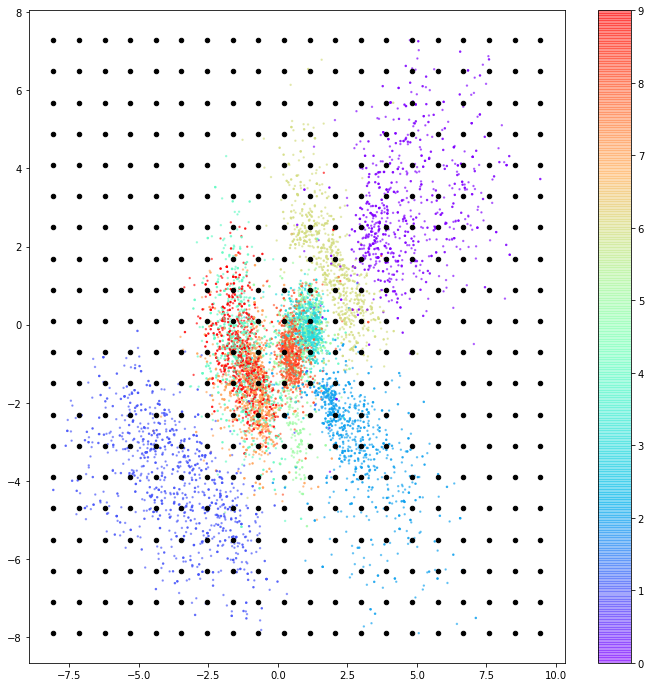

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Encoded 10000 test images for x_test. The points are color-coded with the correct label.
# x_test の10000 個のテスト用画像をエンコードした点。点は正解ラベルで色分けした。
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

# Display the grid as black dots.
# グリッドを黒点として表示する。
ax.scatter(z_grid2[:, 0], z_grid2[:, 1], c='black', alpha=1, s=20)

plt.colorbar(map)   # plt.colorbar() だとエラーになるので注意。pltに対して描画していない場合は、colorbar()の引数にMappableを指定する必要がある。
plt.show()